# Google 'Image Box' analysis

**First import all the libraries we want, together with some formatting options**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 3)
plt.rcParams['font.family'] = 'sans-serif'

pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

## Read in Google Scraper search results table 

In [ ]:
cols = ['requested_at', 'search_query', 'visible_link', 'rank' ,'image_path']

In [ ]:
data = pd.read_csv('./image_box_data.csv', parse_dates=['requested_at'], usecols=cols)
data.head()

In [ ]:
type(data.requested_at[0])

## Programatically identify unique images 
* Read in each image, calculate a unique hash based on the image data, a bit like a fingerprint, and store the hash along with the image filename in a shelf (a persistent dictionary). Many images were repeats, so there were many image filenames stored with the same hash key. 

* The code is based on this blog post: https://realpython.com/blog/python/fingerprinting-images-for-near-duplicate-detection/ which I adapted to work with Python3

In [ ]:
# Check the shelf has content. If nothing is printed out, run the following two scripts/cells
import shelve
db = shelve.open('db.shelve')
for k in db.keys():
    print(k)
db.close()

In [ ]:
%run ../index.py --dataset ./clinton --shelve db.shelve

In [ ]:
%run ../index.py --dataset ./trump --shelve db.shelve

### Add the hash to each row in our `data` dataframe we loaded above

In [ ]:
import shelve

db = shelve.open('db.shelve')

for key in db.keys():   #  For every hash KEY
    for f in db[key]:   # for every file path name ITEM within the KEY
        for index, i in enumerate(data.image_path):      # For every Image path in each row of my DF
            if f in i:                                   # If the ITEM file path is also in the IMAGE PATH of my DF
                data.loc[index, 'image_hash'] = key      # Put the KEY into the 'image_hash' Column

data.to_csv("./hashedDF.csv", index=False)

db.close()

# Open new dataframe with image hashes

In [4]:
hashedDF = pd.read_csv('./hashedDF.csv')
hashedDF.head()

,requested_at,search_query,visible_link,rank,image_path,image_hash
0,2016-09-03 17:21:43,hillary clinton,https://plus.google.com/100418579567144177985,1,./images/4352/4352_1_hillary_clinton_1.jpg,861e1f37179f0e8c
1,2016-09-03 17:21:43,hillary clinton,https://en.wikipedia.org/wiki/Hillary_Clinton,2,./images/4352/4352_2_hillary_clinton_2.jpg,764fce5e4be6b6d2
2,2016-09-03 17:21:43,hillary clinton,http://russia-insider.com/en/node/15518,3,./images/4352/4352_3_hillary_clinton_3.jpg,2f1e0e0e1f1b1b9b
3,2016-09-03 17:21:43,hillary clinton,http://www.cnn.com/election/primaries/candidat...,4,./images/4352/4352_4_hillary_clinton_4.jpg,96970f0706064e86
4,2016-09-03 17:21:43,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4352/4352_5_hillary_clinton_5.jpg,983d7d1c3c1c1c6f


In [3]:
hashedDF['requested_at'] = pd.to_datetime(hashedDF['requested_at'])

In [4]:
type(hashedDF.requested_at[0])

pandas.tslib.Timestamp

In [5]:
len(hashedDF)

645

___
# HILLARY CLINTON DATA

In [5]:
HC = hashedDF[hashedDF.search_query == 'hillary clinton']
HC.to_csv('HC_hashed.csv', index=False)

In [6]:
HC = pd.read_csv('HC_hashed.csv')

In [ ]:
# What are the news sources, and how many times do they appear in the dataset?
HC.visible_link.value_counts()

In [ ]:
# What are the hashes, and how many times does each one appear in the dataset?
HC.image_hash.value_counts()

In [ ]:
print(len(HC.visible_link.unique()))
print(len(HC.image_hash.unique()))

In [ ]:
HC.head()

In [ ]:
print(type(HC.image_hash[0]))
print(type(HC['rank'][0]))
print(type(HC.requested_at[0]))

##  Find an image file representative of each unique hash so we can look at each unique image

In [ ]:
HC_unique_images = HC.groupby('image_hash').first().reset_index()
HC_unique_images

## Collect unique images and put in separate directory

In [ ]:
from shutil import copyfile
import os

In [ ]:
def select_images(df_series, src_dir, dest_dir):
    '''
    provide dataframe series with all the image file names, the directory containing the images, and directory 
    where the unique images should go.
    '''
    try:
        os.mkdir(dest_dir)
        for file in df_series:
            file = file.split('/')[-1] 
            copyfile(src_dir + file, dest_dir + file)
        
    except FileExistsError:
        pass

In [ ]:
select_images(HC_unique_images.image_path,'clinton/', 'clinton_unique/' )

___
# DONALD TRUMP DATA

In [7]:
DT = hashedDF[hashedDF.search_query == 'donald trump']
DT.to_csv('DT_hashed.csv', index=False)
DT = pd.read_csv('DT_hashed.csv')

In [91]:
DT.visible_link.value_counts()

https://plus.google.com/104922825144470163120                                                                                57
https://www.theodysseyonline.com/examples-of-donald-trumps-douchebaggery                                                     51
http://www.slate.com/blogs/the_slatest/2016/02/27/donald_trump_vows_to_curb_press_freedom_through_libel_laws.html            45
http://www.slate.com/blogs/moneybox/2015/08/16/donald_trump_on_immigration_build_border_fence_make_mexico_pay_for_it.html    35
http://www.businessinsider.com/donald-trump-polls-leads-florida-michigan-ohio-2016-3                                         34
https://en.wikipedia.org/wiki/Donald_Trump                                                                                   23
http://www.snopes.com/2016/06/23/donald-trump-rape-lawsuit/                                                                  15
http://www.businessinsider.com/celebrities-who-support-trump-2016-10                                    

In [ ]:
DT.image_hash.value_counts()

## Find an image file representative of each unique hash.

In [ ]:
DT_unique_images = DT.groupby('image_hash').first().reset_index()
DT_unique_images

## Collect unique images and put in separate directory

In [ ]:
select_images(DT_unique_images.image_path,'trump/', 'trump_unique/' )

________
# NEWS SOURCE INFORMATION

In [92]:
HC.visible_link.describe()

count                                               337
unique                                               11
top       https://en.wikipedia.org/wiki/Hillary_Clinton
freq                                                 57
Name: visible_link, dtype: object

In [93]:
DT.visible_link.describe()

count                                               308
unique                                               17
top       https://plus.google.com/104922825144470163120
freq                                                 57
Name: visible_link, dtype: object

## Getting Political Leaning from [Allsides](https://www.allsides.com) from News Sources of all images in basline dataset

![allsides](../logo-all-sides-medium.png) 
Allsides bias data was generously provided by [Allsides](https://www.allsides.com) 



In [8]:
allsides = pd.read_json('../BASELINE/allsides_data.json')
allsides.head()

,allsides_url,bias_rating,news_source,url
0,http://www.allsides.com/node/20678,71,Bruce Braley,http://www.brucebraley.com
1,http://www.allsides.com/node/28762,71,Tallahassee Democrat,http://www.tallahassee.com/
2,http://www.allsides.com/node/20582,71,Mark Udall,http://markudall.com/
3,http://www.allsides.com/node/28766,71,Care 2,http://www.care2.com
4,http://www.allsides.com/node/33340,71,Herald Democrat,http://heralddemocrat.com/


In [8]:
HC_unique_news_sources = []

In [9]:
HC.visible_link.unique()

array(['https://plus.google.com/100418579567144177985',
       'https://en.wikipedia.org/wiki/Hillary_Clinton',
       'http://russia-insider.com/en/node/15518',
       'http://www.cnn.com/election/primaries/candidates/hillary-clinton',
       'https://www.youtube.com/watch?v=-dY77j6uBHI',
       'http://www.biography.com/people/hillary-clinton-9251306',
       'http://time.com/3882496/hillary-clinton-liberal-issues-mainstream-polling/',
       'https://mises.org/blog/hillary-clinton-wins-federal-reserve-primary',
       'http://www.politico.com/story/2016/01/clinton-obama-supreme-court-218259',
       'http://www.politicususa.com/2016/10/02/texas-newspaper-destroys-myth-hillary-clinton-lesser-evils.html',
       'http://www.businessinsider.com/hillary-clinton-donald-trump-helps-her-2015-9'], dtype=object)

In [10]:
HC[HC.visible_link.isnull()]

,requested_at,search_query,visible_link,rank,image_path,image_hash


In [98]:
def get_unique_news_sources(col, source_list):
    print(len(col.unique()))
    for i in col.unique():
        print(i)
        source_list.append(i.split('//')[1].split('/')[0])

In [99]:
get_unique_news_sources(HC.visible_link, HC_unique_news_sources)

11
https://plus.google.com/100418579567144177985
https://en.wikipedia.org/wiki/Hillary_Clinton
http://russia-insider.com/en/node/15518
http://www.cnn.com/election/primaries/candidates/hillary-clinton
https://www.youtube.com/watch?v=-dY77j6uBHI
http://www.biography.com/people/hillary-clinton-9251306
http://time.com/3882496/hillary-clinton-liberal-issues-mainstream-polling/
https://mises.org/blog/hillary-clinton-wins-federal-reserve-primary
http://www.politico.com/story/2016/01/clinton-obama-supreme-court-218259
http://www.politicususa.com/2016/10/02/texas-newspaper-destroys-myth-hillary-clinton-lesser-evils.html
http://www.businessinsider.com/hillary-clinton-donald-trump-helps-her-2015-9


In [100]:
HC_unique_news_sources

['plus.google.com',
 'en.wikipedia.org',
 'russia-insider.com',
 'www.cnn.com',
 'www.youtube.com',
 'www.biography.com',
 'time.com',
 'mises.org',
 'www.politico.com',
 'www.politicususa.com',
 'www.businessinsider.com']

In [101]:
DT_unique_news_sources = []
get_unique_news_sources(DT.visible_link, DT_unique_news_sources)

17
https://plus.google.com/104922825144470163120
https://en.wikipedia.org/wiki/Donald_Trump
http://www.businessinsider.com/donald-trump-polls-leads-florida-michigan-ohio-2016-3
http://www.snopes.com/2016/06/23/donald-trump-rape-lawsuit/
https://www.theodysseyonline.com/examples-of-donald-trumps-douchebaggery
http://www.slate.com/blogs/the_slatest/2016/02/27/donald_trump_vows_to_curb_press_freedom_through_libel_laws.html
http://www.cnn.com/2016/04/18/politics/new-york-city-donald-trump/
http://wonkette.com/605010/donald-trump-so-mad-colorado-fire-marshal-refused-to-let-him-die-in-a-fire
http://wonkette.com/606292/donald-trump-thinks-hillary-clinton-just-doesnt-have-that-presidential-look
http://wonkette.com/tag/donald-trump
http://www.slate.com/blogs/moneybox/2015/08/16/donald_trump_on_immigration_build_border_fence_make_mexico_pay_for_it.html
http://www.nationalreview.com/article/431420/donald-trumps-2016-debate-lies-he-went-bankrupt
http://www.businessinsider.com/donald-trump-celebrit

In [102]:
DT_unique_news_sources

['plus.google.com',
 'en.wikipedia.org',
 'www.businessinsider.com',
 'www.snopes.com',
 'www.theodysseyonline.com',
 'www.slate.com',
 'www.cnn.com',
 'wonkette.com',
 'wonkette.com',
 'wonkette.com',
 'www.slate.com',
 'www.nationalreview.com',
 'www.businessinsider.com',
 'www.headlinepolitics.com',
 'www.reddit.com',
 'www.businessinsider.com',
 'www.businessinsider.com']

In [9]:
def get_url(col):
    col = col.split('//')[1]
    col = col.split('/')[0]
    return col

In [10]:
HC.loc[:, 'news_source_url'] = HC.visible_link.apply(get_url)
DT.loc[:, 'news_source_url'] = DT.visible_link.apply(get_url)

In [13]:
HC.head()

,requested_at,search_query,visible_link,rank,image_path,image_hash,news_source_url
0,2016-09-03 17:21:43,hillary clinton,https://plus.google.com/100418579567144177985,1,./images/4352/4352_1_hillary_clinton_1.jpg,861e1f37179f0e8c,plus.google.com
1,2016-09-03 17:21:43,hillary clinton,https://en.wikipedia.org/wiki/Hillary_Clinton,2,./images/4352/4352_2_hillary_clinton_2.jpg,764fce5e4be6b6d2,en.wikipedia.org
2,2016-09-03 17:21:43,hillary clinton,http://russia-insider.com/en/node/15518,3,./images/4352/4352_3_hillary_clinton_3.jpg,2f1e0e0e1f1b1b9b,russia-insider.com
3,2016-09-03 17:21:43,hillary clinton,http://www.cnn.com/election/primaries/candidat...,4,./images/4352/4352_4_hillary_clinton_4.jpg,96970f0706064e86,www.cnn.com
4,2016-09-03 17:21:43,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4352/4352_5_hillary_clinton_5.jpg,983d7d1c3c1c1c6f,www.youtube.com


In [11]:
allsides.head()

,allsides_url,bias_rating,news_source,url
0,http://www.allsides.com/node/20678,71,Bruce Braley,http://www.brucebraley.com
1,http://www.allsides.com/node/28762,71,Tallahassee Democrat,http://www.tallahassee.com/
2,http://www.allsides.com/node/20582,71,Mark Udall,http://markudall.com/
3,http://www.allsides.com/node/28766,71,Care 2,http://www.care2.com
4,http://www.allsides.com/node/33340,71,Herald Democrat,http://heralddemocrat.com/


In [43]:
def tag_bias_rating(candidate):
    
    candidate.loc['allsides_bias_rating'] = 999
    allsides = pd.read_json('../BASELINE/allsides_data.json')

    for i, valuei in enumerate(candidate.news_source_url):
        for j, valuej in enumerate(allsides.url):
                        
            if 'http' in valuej:
#                 print("Found an HTTP in ", valuej)
                valuej = valuej.split('//')[1]
#                 print(valuej)
            try:
                if valuei in valuej:          
                    print(valuei, valuej)

                    
                if allsides.loc[j, 'bias_rating'] == 71: # Left
                    candidate.loc[i, 'allsides_bias_rating'] = -2
                    
                elif allsides.loc[j, 'bias_rating'] == 72: # Lean left
                    candidate.loc[i, 'allsides_bias_rating'] = -1
                    
                elif allsides.loc[j, 'bias_rating'] == 73: # center
                    candidate.loc[i, 'allsides_bias_rating'] = 0
                    
                elif allsides.loc[j, 'bias_rating'] == 74: # lean right
                    candidate.loc[i, 'allsides_bias_rating'] = 1      
                    
                elif allsides.loc[j, 'bias_rating'] == 75: # Right
                    candidate.loc[i, 'allsides_bias_rating'] = 2                   
                   
                else:
                    candidate.loc[i, 'allsides_bias_rating'] = 999
                    
            except TypeError:
                continue

In [44]:
tag_bias_rating(HC)

www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
time.com www.time.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.youtube.com www.youtube.com
time.com www.time.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.com
www.youtube.com www.youtube.com
www.cnn.com www.cnn.com
www.cnn.com www.cnn.com
www.youtube.com www.youtube.

In [45]:
tag_bias_rating(DT)

www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.cnn.com www.cnn.com
www.businessinsider.com www.businessinsider.com/
www.cnn.com www.cnn.com
www.businessinsider.com www.businessinsider.com/
www.cnn.com www.cnn.com
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.cnn.com www.cnn.com
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.businessinsider.com www.businessinsider.com/
www.nationalreview.com

In [ ]:
for i in allsides.url:
    if 'http' in i:
        print(i.split('//')[1])
    else:
        print(i)

## Getting political leaning from a [Facebook political bias ratings study](http://science.sciencemag.org/content/early/2015/05/06/science.aaa1160)
Data is available [here](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LDJ7MS)

In [24]:
facebook = pd.read_csv('../Facebook_study.csv')

In [25]:
facebook.head()

,p,avg_align,Unnamed: 2,Unnamed: 3,Unnamed: 4,Source,top_level_link,top_level_link_cleaned,avg_align.1,Total_articles
0,6abc.com,-0.5037,NaN,NaN,NaN,The Hill,http://thehill.com/,thehill.com,0.1661,30.0
1,7online.com,-0.4067,NaN,NaN,NaN,Politico,http://www.politico.com/,politico.com,-0.1334,27.0
2,aattp.org,-0.8936,NaN,NaN,NaN,The Washington Post,https://www.washingtonpost.com,washingtonpost.com,-0.2568,25.0
3,abc11.com,-0.1900,NaN,NaN,NaN,The Huffington Post,http://www.huffingtonpost.com/,huffingtonpost.com,-0.6176,21.0
4,abc7.com,-0.3100,NaN,NaN,NaN,New York Times,http://www.nytimes.com/,nytimes.com,-0.5469,18.0


In [26]:
cols = ['p', 'avg_align']
facebook = pd.read_csv('../Facebook_study.csv', usecols=cols)
facebook.head()

,p,avg_align
0,6abc.com,-0.5037
1,7online.com,-0.4067
2,aattp.org,-0.8936
3,abc11.com,-0.1900
4,abc7.com,-0.3100


In [27]:
def tag_facebookbias_rating(candidate):
    
    candidate['facebook_p'] = ''
    candidate['facebookbias_rating'] = 999
    
    count = 0
    for i, valuei in enumerate(candidate.visible_link):
        count += 1
        valuei = valuei.split('//')[1]
        valuei = valuei.split('/')[0]
        print(valuei, count)
        
        for j, valuej in enumerate(facebook.p):
            
            if valuej == valuei:                  
                print(valuei, valuej)
                candidate.loc[i, 'facebookbias_rating'] = facebook.loc[j, 'avg_align']
                candidate.loc[i, 'facebook_p'] = valuej

In [28]:
tag_facebookbias_rating(HC)

plus.google.com 1
en.wikipedia.org 2
en.wikipedia.org en.wikipedia.org
russia-insider.com 3
www.cnn.com 4
www.cnn.com www.cnn.com
www.youtube.com 5
www.youtube.com www.youtube.com
plus.google.com 6
en.wikipedia.org 7
en.wikipedia.org en.wikipedia.org
www.cnn.com 8
www.cnn.com www.cnn.com
russia-insider.com 9
www.youtube.com 10
www.youtube.com www.youtube.com
plus.google.com 11
en.wikipedia.org 12
en.wikipedia.org en.wikipedia.org
www.cnn.com 13
www.cnn.com www.cnn.com
www.youtube.com 14
www.youtube.com www.youtube.com
russia-insider.com 15
plus.google.com 16
en.wikipedia.org 17
en.wikipedia.org en.wikipedia.org
www.cnn.com 18
www.cnn.com www.cnn.com
www.youtube.com 19
www.youtube.com www.youtube.com
russia-insider.com 20
www.biography.com 21
plus.google.com 22
en.wikipedia.org 23
en.wikipedia.org en.wikipedia.org
www.cnn.com 24
www.cnn.com www.cnn.com
www.youtube.com 25
www.youtube.com www.youtube.com
russia-insider.com 26
www.biography.com 27
plus.google.com 28
en.wikipedia.org 29
en.

AttributeError: 'int' object has no attribute 'split'

In [29]:
tag_facebookbias_rating(DT)

plus.google.com 1
en.wikipedia.org 2
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 3
www.businessinsider.com www.businessinsider.com
www.snopes.com 4
www.theodysseyonline.com 5
www.slate.com 6
www.slate.com www.slate.com
plus.google.com 7
en.wikipedia.org 8
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 9
www.businessinsider.com www.businessinsider.com
www.snopes.com 10
www.theodysseyonline.com 11
www.slate.com 12
www.slate.com www.slate.com
plus.google.com 13
en.wikipedia.org 14
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 15
www.businessinsider.com www.businessinsider.com
www.snopes.com 16
www.theodysseyonline.com 17
www.cnn.com 18
www.cnn.com www.cnn.com
plus.google.com 19
en.wikipedia.org 20
en.wikipedia.org en.wikipedia.org
www.businessinsider.com 21
www.businessinsider.com www.businessinsider.com
www.cnn.com 22
www.cnn.com www.cnn.com
www.theodysseyonline.com 23
www.snopes.com 24
plus.google.com 25
en.wikipedia.org 26
en.wikipedia.org en.wikipe

AttributeError: 'int' object has no attribute 'split'

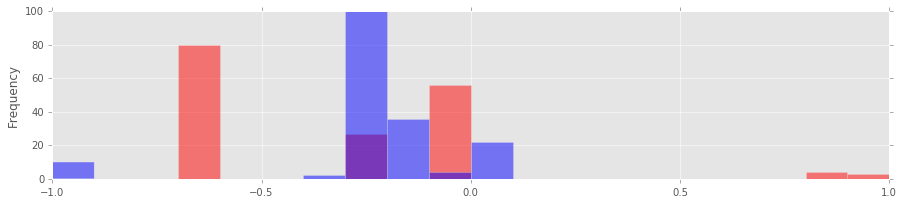

In [127]:
DT.facebookbias_rating[DT.facebookbias_rating < 3].plot.hist(alpha=0.5, bins=20, range=(-1,1), color='red')
HC.facebookbias_rating[HC.facebookbias_rating < 3].plot.hist(alpha=0.5, bins=20, range=(-1,1), color='blue')
plt.savefig('imagebox_facebookbias_hist.png')

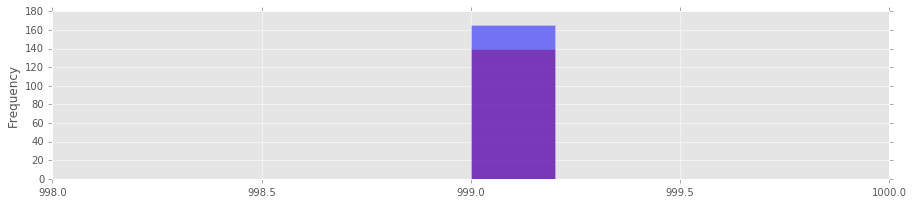

In [128]:
DT.facebookbias_rating[DT.facebookbias_rating > 3].plot.hist(alpha=0.5, bins=10, range=(998,1000), color='red')
HC.facebookbias_rating[HC.facebookbias_rating > 3].plot.hist(alpha=0.5, bins=10, range=(998,1000), color='blue')
plt.savefig('imagebox_facebookbias_hist_unknowns.png')

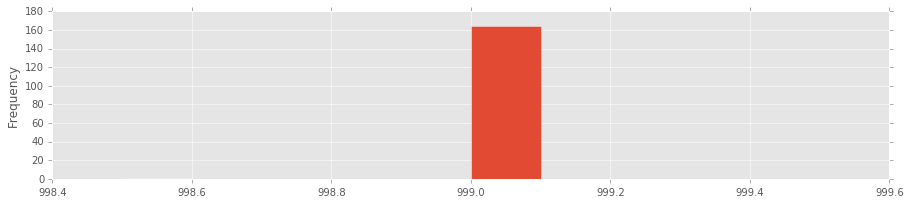

In [31]:
HC.facebookbias_rating[HC.facebookbias_rating > 3].plot.hist()

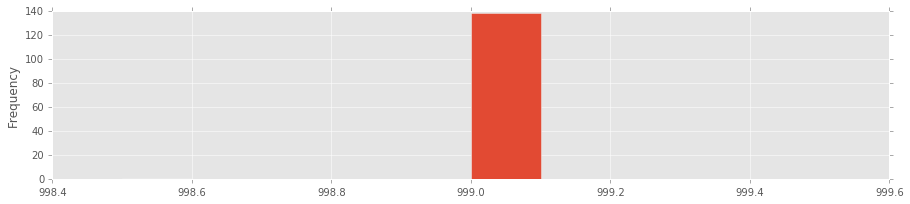

In [32]:
DT.facebookbias_rating[DT.facebookbias_rating > 3].plot.hist()

In [33]:
HC.facebookbias_rating.value_counts()

 999.0000    164
-0.2145       57
-0.2705       43
-0.1334       36
 0.0634       22
-0.9037       10
-0.0585        4
-0.3336        2
Name: facebookbias_rating, dtype: int64

In [34]:
DT.facebookbias_rating.value_counts()

 999.0000    139
-0.6813       80
-0.0585       56
-0.2145       23
-0.2705        4
 0.8898        4
 0.9009        3
Name: facebookbias_rating, dtype: int64

# Combining ratings from Allsides and Facebook, together with crowdsourced political bias ratings from [Mondo Times](www.mondotimes.com) and author's judgement

#### First, Facebook ratings were categoriesed into 2, 1, 0, -1, and -2 integers so as to be compatable with the Allsides data. Between-category thresholds were selected so as to make each bucket equal in float range of values. 

In [35]:
def convert_facebookbias_toInts(col):
    
    if col >= 0.6 and col <= 1:
        return 2
    elif col >= 0.2 and col < 0.6:
        return 1
    elif col > -0.2 and col < 0.2:
        return 0
    elif col > -0.6 and col <= -0.2:
        return -1
    elif col <= -0.6:
        return -2
    elif col == 999:
        return 999
    else:
        return 999

In [36]:
HC['facebook_int'] = HC.facebookbias_rating.apply(convert_facebookbias_toInts)
DT['facebook_int'] = DT.facebookbias_rating.apply(convert_facebookbias_toInts)

In [37]:
HC.head()

,requested_at,search_query,visible_link,rank,image_path,image_hash,news_source_url,bias_rating,facebook_p,facebookbias_rating,facebook_int
0,2016-09-03 17:21:43,hillary clinton,https://plus.google.com/100418579567144177985,1,./images/4352/4352_1_hillary_clinton_1.jpg,861e1f37179f0e8c,plus.google.com,999.0,,999.0000,999
1,2016-09-03 17:21:43,hillary clinton,https://en.wikipedia.org/wiki/Hillary_Clinton,2,./images/4352/4352_2_hillary_clinton_2.jpg,764fce5e4be6b6d2,en.wikipedia.org,999.0,en.wikipedia.org,-0.2145,-1
2,2016-09-03 17:21:43,hillary clinton,http://russia-insider.com/en/node/15518,3,./images/4352/4352_3_hillary_clinton_3.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0000,999
3,2016-09-03 17:21:43,hillary clinton,http://www.cnn.com/election/primaries/candidat...,4,./images/4352/4352_4_hillary_clinton_4.jpg,96970f0706064e86,www.cnn.com,999.0,www.cnn.com,-0.2705,-1
4,2016-09-03 17:21:43,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4352/4352_5_hillary_clinton_5.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0


In [38]:
HC.facebook_int.value_counts()

 999    164
-1      102
 0       62
-2       10
Name: facebook_int, dtype: int64

In [39]:
DT.facebook_int.value_counts()

 999    139
-2       80
 0       56
-1       27
 2        7
Name: facebook_int, dtype: int64

#### Next, ratings from Allsides and the Facebook study were combined. Where ratings from both Allsides and Facebook are absent, or disagree, bias rating was decided by Mondo Times where an outlet received more than 20 votes, and /or the author based on outlets' "About" pages and other information. Where doubt remained, or ratings are not applicable (eg. Getty Images), `Unknown / Unreliable` was assigned. 

In [58]:
def combine_ratings(candidate):
    
    candidate['combine_rating'] = 'Not Rated'
    
    for i, valuei in enumerate(candidate.allsides_bias_rating):
        
        try:
            # STATEMENTS FOR IF BOTH RATINGS AGREE:
            # Both bias ratings say LEFT
            if (valuei < 0) and (candidate.loc[i, 'facebook_int'] < 0):
                print(valuei, candidate.loc[i, 'facebook_int'],  "Left")
                candidate.loc[i, 'combine_rating'] = "Left"
          
            # Both bias ratings say CENTER
            elif (valuei == 0.0) and (candidate.loc[i, 'facebook_int'] == 0):
                print(valuei, candidate.loc[i, 'facebook_int'],  "Center")
                candidate.loc[i, 'combine_rating'] = "Center"
        
            # Both bias ratings say RIGHT
            elif (0 < valuei < 3) and (0 < candidate.loc[i, 'facebook_int'] < 3):
                print(valuei, candidate.loc[i, 'facebook_int'], "Right")
                candidate.loc[i, 'combine_rating'] = "Right"
        
            # STATEMENTS FOR IF RATINGS ARE ONLY PRESENT IN ONE (ALLSIDES OR FACEBOOK STUDY)
            # Only one scale has a rating of LEFT, while the other has no entry 
            elif (valuei < 0 and candidate.loc[i, 'facebook_int'] == 999) or (valuei == 999 and candidate.loc[i, 'facebook_int'] < 0):
                print(valuei, candidate.loc[i, 'facebook_int'],  "Left")
                candidate.loc[i, 'combine_rating'] = "Left"
            
            # Only one scale has a rating of CENTER, while the other has no entry 
            elif (valuei == 0 and candidate.loc[i, 'facebook_int'] == 999) or (valuei  == 999 and candidate.loc[i, 'facebook_int'] == 0):
                print(valuei, candidate.loc[i, 'facebook_int'],  "Center")
                candidate.loc[i, 'combine_rating'] = "Center"
        
            # Only one scale has a rating of RIGHT, while the other has no entry
            elif (0 < valuei < 3 and candidate.loc[i, 'facebook_int'] == 999) or (valuei  == 999 and 0 < candidate.loc[i, 'facebook_int'] < 3):
                print(valuei, candidate.loc[i, 'facebook_int'], "Right")
                candidate.loc[i, 'combine_rating'] = "Right"
             
            # ALL OTHER RATINGS ARE EITHER ABSENT FOR BOTH SCALES OR THE SCALES DISAGREE
            else:
                print(valuei, candidate.loc[i, 'facebook_int'], "Not Rated")
                candidate.loc[i, 'combine_rating'] = "Unknown / unreliable"
                
        except KeyError:
            continue

In [60]:
combine_ratings(HC)

999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 999 Not Rated
999.0 0 Center
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 999 Not Rated
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Ra

In [57]:
len(HC)

339

In [61]:
combine_ratings(DT)

999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -2 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -2 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 -1 Left
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 -1 Left
999.0 999 Not Rated
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 999 Not Rated
999.0 -1 Left
999.0 0 Center
999.0 

#### Make list of unique news sources, combine lists together from HC and DT, and output to a csv:

In [62]:
HC_Unrated = HC[HC.combine_rating == "Unknown / unreliable"]
DT_Unrated = DT[DT.combine_rating == "Unknown / unreliable"]

In [65]:
HC_Unrated.news_source_url.unique()

array(['plus.google.com', 'russia-insider.com', 'www.biography.com',
       'mises.org'], dtype=object)

In [66]:
DT_Unrated.news_source_url.unique()

array(['plus.google.com', 'www.snopes.com', 'www.theodysseyonline.com',
       'wonkette.com', 'www.reddit.com'], dtype=object)

In [75]:
Unrated_newssource_list = HC_Unrated.news_source_url.unique().tolist()
DT_Unrated_newssource_list = DT_Unrated.news_source_url.unique().tolist()

In [76]:
print(len(Unrated_newssource_list))
print(len(DT_Unrated_newssource_list))

4
5


In [77]:
Unrated_newssource_list

['plus.google.com', 'russia-insider.com', 'www.biography.com', 'mises.org']

In [78]:
DT_Unrated_newssource_list

['plus.google.com',
 'www.snopes.com',
 'www.theodysseyonline.com',
 'wonkette.com',
 'www.reddit.com']

In [83]:
HC[HC.news_source_url == 'www.youtube.com']

,requested_at,search_query,visible_link,rank,image_path,image_hash,news_source_url,bias_rating,facebook_p,facebookbias_rating,facebook_int,combine_rating,allsides_bias_rating
4,2016-09-03 17:21:43,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4352/4352_5_hillary_clinton_5.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
9,2016-09-03 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4365/4365_31_hillary_clinton_5.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
13,2016-09-04 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,4,./images/4437/4437_30_hillary_clinton_4.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
18,2016-09-05 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,4,./images/4509/4509_29_hillary_clinton_4.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
24,2016-09-06 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,4,./images/4581/4581_29_hillary_clinton_4.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
31,2016-09-07 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,5,./images/4653/4653_30_hillary_clinton_5.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
36,2016-09-08 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,4,./images/4725/4725_28_hillary_clinton_4.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
41,2016-09-09 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,3,./images/4797/4797_27_hillary_clinton_3.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
46,2016-09-10 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,3,./images/4869/4869_27_hillary_clinton_3.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0
52,2016-09-11 18:28:22,hillary clinton,https://www.youtube.com/watch?v=-dY77j6uBHI,3,./images/4941/4941_27_hillary_clinton_3.jpg,983d7d1c3c1c1c6f,www.youtube.com,999.0,www.youtube.com,0.0634,0,Center,999.0


Despite YouTube being in the Facebook study, the channel observed here in Hillary Clinton's list is a channel that displays a distinct bias toward Donald Trump and against Hillary Clinton. Therefore, it will be manually rated.

In addition, Reddit, which is also channel-based, will be rated on the specific channel, and not the overall site.

In [79]:
Unrated_newssource_list.append('www.youtube.com')

In [81]:
for i in DT_Unrated_newssource_list:
    if i not in Unrated_newssource_list:
        Unrated_newssource_list.append(i)

In [73]:
len(Unrated_newssource_list)

9

In [82]:
#tmp = pd.DataFrame(Unrated_newssource_list, columns=["news_source"])
#tmp.to_csv('unrated_newssources_imagebox.csv', index=False)

#### Read in my manual bias ratings:

In [133]:
manual_rating = pd.read_csv('unrated_newssources_imagebox.csv')

In [134]:
manual_rating

,news_source,final_rating_DT,final_rating_HC,Unnamed: 3
0,plus.google.com,1.0,-1.0,NaN
1,russia-insider.com,NaN,2.0,NaN
2,www.biography.com,NaN,-1.0,NaN
3,mises.org,NaN,0.0,They self-identify as non-partisan and non-pol...
4,www.youtube.com,NaN,2.0,NaN
5,www.snopes.com,0.0,NaN,NaN
6,www.theodysseyonline.com,-1.0,NaN,"""democratizing content"" not clear if the reade..."
7,wonkette.com,-1.0,NaN,NaN
8,www.reddit.com,2.0,NaN,NaN


In [135]:
def merge_manual_ratings(candidate, col):
    
    candidate['final_rating'] = ''
    
    for i, valuei in enumerate(candidate.news_source_url):
        for j, valuej in enumerate(manual_rating.news_source):
            
            if (valuei == valuej):
                print(valuei, valuej, manual_rating.loc[j, col])
                
                try:
                    if manual_rating.loc[j, col] < 0:
                        print("Left")
                        candidate.loc[i, 'final_rating'] = "Left"
                    
                    elif manual_rating.loc[j, col] == 0:
                        print("Center")
                        candidate.loc[i, 'final_rating'] = "Center"
                    
                    elif 999 > manual_rating.loc[j, col] > 0:
                        print("Right")
                        candidate.loc[i, 'final_rating'] = "Right"
                    
                    elif manual_rating.loc[j, col] == 999:
                        print("Unknown/Unreliable")
                        candidate.loc[i, 'final_rating'] = "Unknown / unreliable"
            
                except KeyError:
                    continue
    
    for i, valuei in enumerate(candidate.final_rating):
        if valuei == '':
            try:
                print("currently empty. Let's fill it up!!")
                candidate.loc[i, 'final_rating'] = candidate.loc[i, 'combine_rating']
            except KeyError:
                continue

In [136]:
merge_manual_ratings(HC, 'final_rating_HC')
merge_manual_ratings(DT, 'final_rating_DT')

plus.google.com plus.google.com -1.0
Left
russia-insider.com russia-insider.com 2.0
Right
www.youtube.com www.youtube.com 2.0
Right
plus.google.com plus.google.com -1.0
Left
russia-insider.com russia-insider.com 2.0
Right
www.youtube.com www.youtube.com 2.0
Right
plus.google.com plus.google.com -1.0
Left
www.youtube.com www.youtube.com 2.0
Right
russia-insider.com russia-insider.com 2.0
Right
plus.google.com plus.google.com -1.0
Left
www.youtube.com www.youtube.com 2.0
Right
russia-insider.com russia-insider.com 2.0
Right
www.biography.com www.biography.com -1.0
Left
plus.google.com plus.google.com -1.0
Left
www.youtube.com www.youtube.com 2.0
Right
russia-insider.com russia-insider.com 2.0
Right
www.biography.com www.biography.com -1.0
Left
plus.google.com plus.google.com -1.0
Left
russia-insider.com russia-insider.com 2.0
Right
www.youtube.com www.youtube.com 2.0
Right
www.biography.com www.biography.com -1.0
Left
plus.google.com plus.google.com -1.0
Left
www.youtube.com www.youtube.

In [137]:
HC.allsides_bias_rating.value_counts()

999.0    337
Name: allsides_bias_rating, dtype: int64

In [138]:
DT.allsides_bias_rating.value_counts()

999.0    308
Name: allsides_bias_rating, dtype: int64

In [139]:
HC.facebookbias_rating.value_counts()

 999.0000    165
-0.2145       57
-0.2705       43
-0.1334       36
 0.0634       22
-0.9037       10
-0.0585        4
-0.3336        2
Name: facebookbias_rating, dtype: int64

In [140]:
DT.facebookbias_rating.value_counts()

 999.0000    140
-0.6813       80
-0.0585       56
-0.2145       23
-0.2705        4
 0.8898        4
 0.9009        3
Name: facebookbias_rating, dtype: int64

In [141]:
HC.final_rating.value_counts()

Left      221
Right      75
Center     41
            2
Name: final_rating, dtype: int64

In [146]:
DT.final_rating.value_counts()

Left      172
Center     71
Right      65
            2
Name: final_rating, dtype: int64

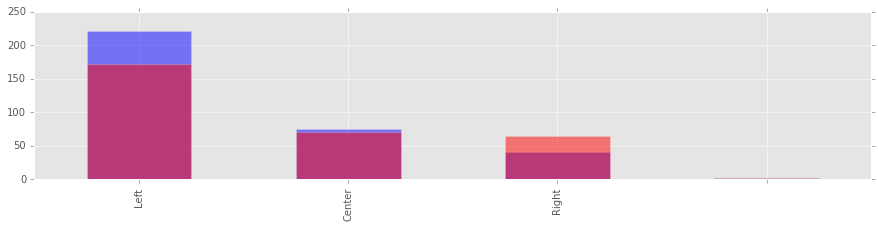

In [143]:
HC.final_rating.value_counts().plot(kind='bar', alpha=0.5, color='blue')
DT.final_rating.value_counts().plot(kind='bar', alpha=0.5, color='red')

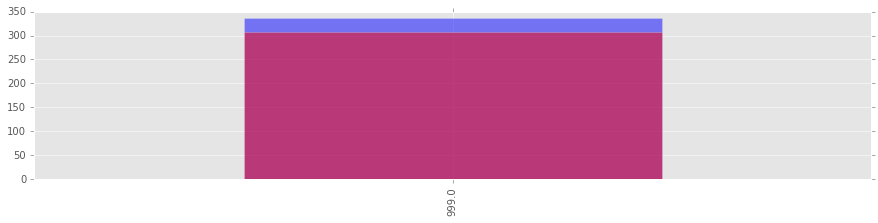

In [144]:
HC.allsides_bias_rating.value_counts().plot(kind='bar', alpha=0.5, color='blue')
DT.allsides_bias_rating.value_counts().plot(kind='bar', alpha=0.5, color='red')

In [131]:
HC[HC.news_source_url == 'russia-insider.com']

,requested_at,search_query,visible_link,rank,image_path,image_hash,news_source_url,bias_rating,facebook_p,facebookbias_rating,facebook_int,combine_rating,allsides_bias_rating,final_rating
2,2016-09-03 17:21:43,hillary clinton,http://russia-insider.com/en/node/15518,3,./images/4352/4352_3_hillary_clinton_3.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
8,2016-09-03 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,4,./images/4365/4365_30_hillary_clinton_4.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
14,2016-09-04 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,5,./images/4437/4437_31_hillary_clinton_5.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
19,2016-09-05 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,5,./images/4509/4509_30_hillary_clinton_5.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
25,2016-09-06 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,5,./images/4581/4581_30_hillary_clinton_5.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
30,2016-09-07 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,4,./images/4653/4653_29_hillary_clinton_4.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
37,2016-09-08 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,5,./images/4725/4725_29_hillary_clinton_5.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
42,2016-09-09 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,4,./images/4797/4797_28_hillary_clinton_4.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
47,2016-09-10 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,4,./images/4869/4869_28_hillary_clinton_4.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right
53,2016-09-11 18:28:22,hillary clinton,http://russia-insider.com/en/node/15518,4,./images/4941/4941_28_hillary_clinton_4.jpg,2f1e0e0e1f1b1b9b,russia-insider.com,999.0,,999.0,999,Unknown / unreliable,999.0,Right


In [145]:
DT[DT.final_rating == 'Unknown / unreliable']

,requested_at,search_query,visible_link,rank,image_path,image_hash,news_source_url,bias_rating,facebook_p,facebookbias_rating,facebook_int,allsides_bias_rating,combine_rating,final_rating


In [147]:
HC.to_csv('HC_imagebox_full_ratings.csv', index=False)
DT.to_csv('DT_imagebox_full_ratings.csv', index=False)

In [148]:
HC.columns

Index(['requested_at', 'search_query', 'visible_link', 'rank', 'image_path', 'image_hash', 'news_source_url', 'bias_rating', 'facebook_p', 'facebookbias_rating', 'facebook_int', 'combine_rating', 'allsides_bias_rating', 'final_rating'], dtype='object')